In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import scipy.special as sp

In [2]:
#Define constants
G_SI = 4.49e-15           # gravitational constant, Mpc^3/ (Gyrs^2 * Msolar)
c_SI = 3.06e2             # speed of light in vacuum, Mpc/Gyrs
H0_SI = 6.89e-2           # Gyrs^-1, which is 67.4 km/(s*Mpc) -- a reasonable standard H0 


In [3]:
# Convert to proper units, i.e.,
h = 0.674
GyrstoHT = h/9.778
MpctoHL = h/3000
c = 1 # correct speed of light, consistent with Ellis-Bruni formalism
G = G_SI * (MpctoHL**3) / (GyrstoHT**2) # convert to HL^2/(HT^2 * M_solar)
H0 = 1 # convert to HT^-1

In [4]:
# background normalised energy densities and quantities
zlim = 20
OmegaM0 = 0.315 
OmegaL0 = 1 - OmegaM0
rhoF0 = 3*(H0**2)*OmegaM0/(8*np.pi*G)
aFi = (1/(1+zlim))
rhoFi = rhoF0/(aFi**3)

# Background functions

def OmegaM(z): # Omega Matter
    term1 = OmegaM0*(1+z)**3
    term2= (OmegaL0+OmegaM0*(1+z)**3)
    return term1/term2

def OmegaL(z): # Omega Lambda
    return OmegaL0/(OmegaL0+OmegaM0*(1+z)**3)

def HF(z): # Hubble parameter
    return H0*np.sqrt(OmegaL0 + OmegaM0*(1+z)**3)

def HF_prime(z): # Hubble parameter
    return (HF(z+1e-5)-HF(z))/1e-5

def aF(z):
    return 1/(1+z)

def rhoF(z):
    return rhoFi*((aFi/aF(z))**3)

def dzdt(z):
    return -(1+z)*HF(z)

def zdot_pr(z):
    return -(1+z)*HF(z)

def t(z):
    c1 = 2/(3*H0*np.sqrt(OmegaL0))
    c2 = np.sqrt(OmegaL0/OmegaM0)*(aF(z)**(3/2))
    return c1*np.arcsinh(c2)

In [5]:
def qplus(z):
    u = (1+z)**-3
    x = OmegaL0*u/(OmegaM0 + OmegaL0*u)
    const = (5/6)*( (OmegaM0/OmegaL0)**(1/3) )
    Bx = sp.beta(5/6, 2/3) * sp.betainc(5/6, 2/3, x)
    f = np.sqrt(1 + OmegaM0/(OmegaL0*u))
    return const*Bx*f

def qplus_prime(z):
    epsilon = 1e-5
    return (qplus(z+epsilon)-qplus(z))/epsilon

def qplus_dot(z):
    return qplus_prime(z)*dzdt(z)

In [6]:
# Set parameters
deltai = -qplus(zlim)*(2e-1)
rhodi = rhoFi*(1+deltai)
xiOne = qplus(zlim)/qplus_dot(zlim)
beta = -deltai/xiOne

In [7]:
#RZA Functions: averaged quantities

def xi(z):
    return (qplus(z)-qplus(zlim))/qplus_dot(zlim)

def xi_prime(z):
    return qplus_prime(z)/qplus_dot(zlim)

def a_pr(z):
    return aF(z)*((1+beta*xi(z))**(1/3))

def Theta_pr(z):
    term1 = 3*HF(z)
    term2 = (beta*xi_prime(z)*dzdt(z))/(1+beta*xi(z))
    return term1 + term2

def Hprime_pr(z):
    return (Theta_pr(z+1e-5)/3-Theta_pr(z)/3)/1e-5
    
def QD(z):
    term1 = -2/3
    term2 = (beta*xi_prime(z)*dzdt(z))**2
    term3 = (1+beta*xi(z))**2
    return term1*term2/term3

def RD(z):
    term1 = -4*beta/(1+beta*xi(z))
    term2 = HF(z)*xi_prime(z)*dzdt(z)
    term3 = 4*np.pi*G*rhoF(z)*(xi(z)+xiOne)
    return (term2+term3)*term1

def rhod_pr(z):
    return rhodi*((a_pr(zlim)/a_pr(z))**3)
    

In [8]:
zf = np.linspace(zlim,0,100000) # create array for splines
# Define arrays and splines
RD_arr = RD(zf) # array over zf
RD_spline = CubicSpline(np.flip(zf), np.flip(RD_arr)) # spline
dRD_dz =  RD_spline.derivative() # its derivative
QD_arr = QD(zf) # array over zf
QD_spline = CubicSpline(np.flip(zf), np.flip(QD_arr)) #spline
dQD_dz =  QD_spline.derivative() #its derivative

In [9]:
#Fast R
def RD_fast(z):
    return RD_spline(z)

#Fast Q
def QD_fast(z):
    return QD_spline(z)

#Effective fluid density
def rhoEff_pr(z):
    return -QD_fast(z)/(16*np.pi*G) -RD_fast(z)/(16*np.pi*G)

#Effective fluid pressure
def pEff_pr(z):
    return -QD_fast(z)/(16*np.pi*G) + RD_fast(z)/(48*np.pi*G)

#Effective fluid Eos
def wEff_pr(z):
    return pEff_pr(z)/rhoEff_pr(z)

#Effective fluid "sound" velocity
def cs2Eff_pr(z):
    drhoEff_dz = (rhoEff_pr(z+1e-3)-rhoEff_pr(z))/1e-3
    dpEff_dz = (pEff_pr(z+1e-3)-pEff_pr(z))/1e-3
    return dpEff_dz/drhoEff_dz

In [10]:
# Extract quantities of interest for energy balance and eff characterisation
RDarr=np.array(RD(zf))
QDarr=np.array(QD(zf))
Harr=np.array((Theta_pr(zf)/3))
rhodarr=np.array(rhod_pr(zf))
wEffarr=np.array(wEff_pr(zf))
cs2Effarr=np.array(cs2Eff_pr(zf))
aprarray = np.array(a_pr(zf))


In [11]:
# Convert in normalised quantities
OmegaR = -(c**2)*RDarr/(6*Harr**2)
OmegaQ = -QDarr/(6*Harr**2)
OmegaM = 8*np.pi*G*rhodarr/(3*Harr**2)
OmegaL = 1 - OmegaQ - OmegaR - OmegaM
Lambda = OmegaL[-1]*3*(Harr[-1]**2) # Extract Lambda

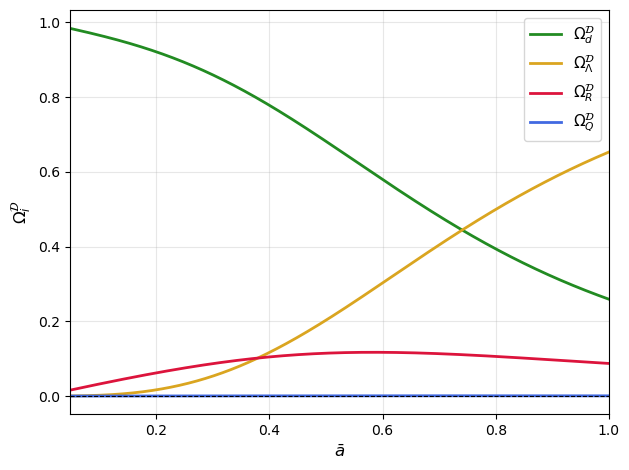

In [26]:
plt.plot(aF(zf), OmegaM, label=r'$\Omega^\mathcal{D}_d$', color='forestgreen', lw=2)
plt.plot(aF(zf), OmegaL, label=r'$\Omega^\mathcal{D}_\Lambda$', color='goldenrod', lw=2)
plt.plot(aF(zf), OmegaR, label=r'$\Omega^\mathcal{D}_R$', color='crimson', lw=2)
plt.plot(aF(zf), OmegaQ, label=r'$\Omega^\mathcal{D}_Q$', color='royalblue', lw=2)
plt.axhline(0, color='k', linestyle='--', lw=0.8)
plt.xlabel(r'$\bar{a}$', fontsize=12)
plt.ylabel(r'$\Omega^\mathcal{D}_i$', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xlim([min(aF(zf)),1])
plt.tight_layout()
plt.savefig('RZA_energy_balance.pdf', format='pdf')
plt.show()


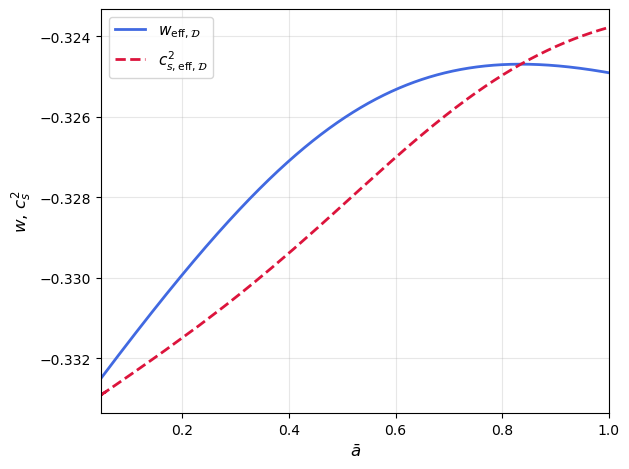

In [13]:
plt.plot(aF(zf), wEffarr, label=r'$w_{\mathrm{eff},\mathcal{D}}$', color='royalblue', lw=2)
plt.plot(aF(zf), cs2Effarr, '--', label=r'$c_{s,\mathrm{eff},\mathcal{D}}^2$', color='crimson', lw=2)
plt.xlabel(r'$\bar{a}$', fontsize=12)
plt.ylabel(r'$w$, $c_{s}^2$', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xlim([min(aF(zf)),1])
plt.tight_layout()
plt.savefig('RZA_wcs.pdf', format='pdf')
plt.show()

In [14]:
def solnum_barotropic(k,z_eval,ic):
    #Define the (non-trivial) single entries in the matrices

    def A21(z):
        return -4*np.pi*G*rhod_pr(z)

    def A22(z):
        return -(2/3)*Theta_pr(z)

    def A23(z):
        term1 = -4*np.pi*G*rhoEff_pr(z)
        term2 = 1+3*cs2Eff_pr(z)
        return term1*term2

    def A32(z):
        return -(1+wEff_pr(z))

    def A33(z):
        return (wEff_pr(z)+cs2Eff_pr(z))*Theta_pr(z)

    def A34(z):
        return (k**2)/a_pr(z)

    def A43(z):
        return -cs2Eff_pr(z)/a_pr(z)

    def A44(z):
        term1 = Theta_pr(z)/3
        term2 = 3*wEff_pr(z)-1
        return term1*term2
    # Define a 4x4 redshift-dependent matrix A(z) which relates the perturbations
    # 1. Delta_dust; 2. Expansion 3.; Delta_eff; 4. Tilt_eff*(1+wEff)
    def A(z):
        return (1/zdot_pr(z))*np.array([
            [  0,        -1,        0,          0   ],
            [A21(z),    A22(z),   A23(z),       0   ],
            [  0,       A32(z),   A33(z),     A34(z)],
            [  0,         0,      A43(z),     A44(z)]
        ])
    
    # Define the ODE system: dv/dz = A(z) @ v
    def system(z, v):
        return A(z) @ v
    
    z_span = np.array([z_eval[0],z_eval[-1]])
    # Solve the system
    sol = solve_ivp(system, z_span, ic, t_eval=z_eval)  

    return sol

In [15]:
def solnum_comoving(z_eval,ic):
    #Define the (non-trivial) single entries in the matrices

    def A21(z):
        return -4*np.pi*G*rhod_pr(z)

    def A22(z):
        return -(2/3)*Theta_pr(z)

    def A23(z):
        return -4*np.pi*G*rhoEff_pr(z)

    def A32(z):
        return -(1+wEff_pr(z))

    def A33(z):
        return wEff_pr(z)*Theta_pr(z)

    # Define a 3x3 redshift-dependent matrix A(z) which relates the perturbations
    # 1. Delta_dust; 2. Expansion 3.; Delta_eff;
    def A(z):
        return (1/zdot_pr(z))*np.array([
            [  0,        -1,        0     ],
            [A21(z),    A22(z),   A23(z)  ],
            [  0,       A32(z),   A33(z)  ]
        ])
    
    # Define the ODE system: dv/dz = A(z) @ v
    def system(z, v):
        return A(z) @ v
    
    z_span = np.array([z_eval[0],z_eval[-1]])
    # Remove the V_Eff initial condition
    ic_new = ic[:-1]
    # Solve the system
    sol = solve_ivp(system, z_span, ic_new, t_eval=z_eval)  

    return sol

In [16]:
# Mezaros Approximation
def solnum_mezaros(z_eval,ic):

    def perturbation_equation(z,y):
        delta, delta_dot = y
        H = Theta_pr(z)/3
        Hprime = Hprime_pr(z)
        rho_t = rhod_pr(z)
        delta_ddot = (4 * np.pi * G * rho_t * delta - 2 * H * (1+z) * (Hprime * (1+z) - H) * delta_dot)/(((1+z) * H)**2)
        return [delta_dot, delta_ddot]
    
    z_span = np.array([z_eval[0],z_eval[-1]])
    factor = zdot_pr(z_eval[0])**(-1)
    ic_new = np.array([ic[0],-ic[1]*factor])
    
    sol = solve_ivp(perturbation_equation,z_span,ic_new,t_eval=z_eval)

    return sol

In [33]:
# Redshift range and evaluation points
zci = 20
z_span = (zci, 0)
CMB_factor = 6.6e-2
# Initial condition (4D vector) fixed to be the initial condition for a typical dust perturbation on a co-moving scale of 150 Mpc/h at present time in the concordance model
ic = [CMB_factor*qplus(20), -CMB_factor*qplus_dot(20), 0, 0]

z_eval = np.flip(np.arange(0,zci-0.01,0.01))

In [34]:
sol_comoving = solnum_comoving(z_eval,ic)
sol_mezaros = solnum_mezaros(z_eval,ic)

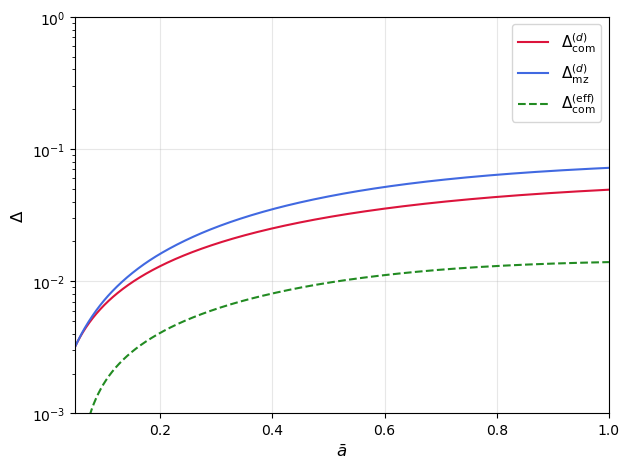

In [36]:
labels_com = [r'$\Delta^{(d)}_{\mathrm{com}}$', r'$\Delta^{(\mathrm{eff})}_{\mathrm{com}}$']
labels_mz = [r'$\Delta^{(d)}_{\mathrm{mz}}$']

plt.plot([aF(z) for z in sol_comoving.t], sol_comoving.y[0], label=labels_com[0], color = 'crimson')
plt.plot([aF(z) for z in sol_mezaros.t], sol_mezaros.y[0], label=labels_mz, color = 'royalblue')
plt.plot([aF(z) for z in sol_comoving.t], sol_comoving.y[2], '--', label=labels_com[1], color = 'forestgreen')  
plt.xlabel(r'$\bar{a}$', fontsize=12)
plt.ylabel(r'$\Delta$', fontsize=12)
plt.xlim([aF(zci),1])
plt.ylim([1e-3,1])
plt.grid(alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.legend(fontsize=11)
plt.savefig('All_Perturbations_RZA.pdf', format='pdf')
plt.show()

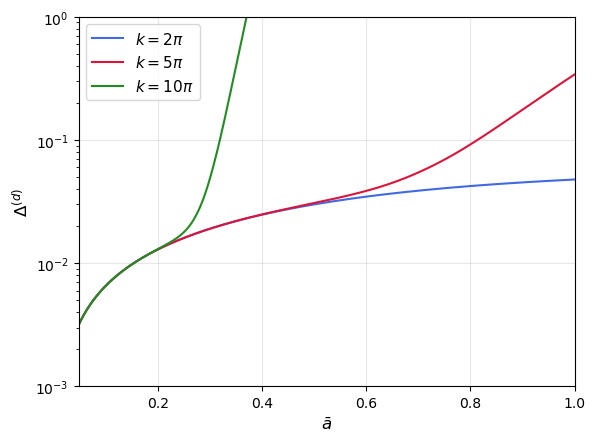

In [37]:
k_vector = [2*np.pi, 5*np.pi, 10*np.pi]
labels_k = [r'$k = 2\pi$',r'$k = 5\pi$',r'$k = 10\pi$']
sol_bar = {}
colors = ['royalblue','crimson','forestgreen']


for i in range(len(k_vector)):
    k = k_vector[i]
    sol_bar[k] = solnum_barotropic(k,z_eval,ic)
    plt.plot([aF(z) for z in sol_bar[k].t], sol_bar[k].y[0], label=labels_k[i], color = colors[i])
    
plt.ylim([1e-3,1])
plt.yscale('log')
plt.xlabel(r'$\bar{a}$', fontsize=12)
plt.ylabel(r'$\Delta^{(d)}$', fontsize=12)
plt.xlim([aF(zci),1])
plt.grid(alpha=0.3)
plt.legend(fontsize=11)
plt.savefig('Bar_Dusts_RZA.pdf', format='pdf')
plt.show()

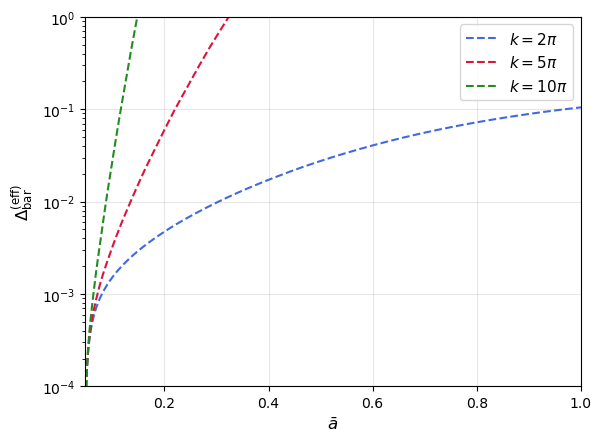

In [39]:
for i in range(len(k_vector)):
    k = k_vector[i]
    plt.plot([aF(z) for z in sol_bar[k].t], sol_bar[k].y[2], '--', label=labels_k[i], color = colors[i])
    

plt.ylim([1e-4,1])
plt.yscale('log')
plt.xlabel(r'$\bar{a}$', fontsize=12)
plt.ylabel(r'$\Delta^{\mathrm{(eff)}}_\mathrm{bar}$', fontsize=12)
plt.xlim([aF(zci),1])
plt.grid(alpha=0.3)
plt.legend(fontsize=11)
plt.savefig('Bar_eff_RZA.pdf', format='pdf')
plt.show()